In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# path to the train, validation and test dataset

train_path = 'dakshina_dataset_v1.0\hi\lexicons\hi.translit.sampled.train.tsv'
val_path = 'dakshina_dataset_v1.0\hi\lexicons\hi.translit.sampled.dev.tsv'
test_path = 'dakshina_dataset_v1.0\hi\lexicons\hi.translit.sampled.test.tsv'

# creating the corpus and vectorizing the data

train_X = []
train_Y = []
input_corpus = set()
output_corpus = set()

with open(train_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
    
for line in lines[:len(lines) - 1]:
    target_text, input_text, _ = line.split("\t")
    #using "tab" as the "start sequence" character for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    train_X.append(input_text)
    train_Y.append(target_text)
    for char in input_text:
        input_corpus.add(char)
    for char in target_text:
        output_corpus.add(char)

# ' ' is used to fill the empty spaces of shorter sequences
input_corpus.add(" ")
output_corpus.add(" ")
input_corpus = sorted(list(input_corpus))
output_corpus = sorted(list(output_corpus))
num_encoder_tokens = len(input_corpus)
num_decoder_tokens = len(output_corpus)
max_encoder_seq_length = max([len(txt) for txt in train_X])
max_decoder_seq_length = max([len(txt) for txt in train_Y])

val_X = []
val_Y = []
with open(val_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
    
for line in lines[:len(lines) - 1]:
    target_text, input_text, _ = line.split("\t")
    target_text = "\t" + target_text + "\n"
    val_X.append(input_text)
    val_Y.append(target_text)

In [3]:
print("Number of samples:", len(train_X))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 44204
Number of unique input tokens: 27
Number of unique output tokens: 66
Max sequence length for inputs: 20
Max sequence length for outputs: 21


In [4]:
input_char_index = dict([(char, i) for i, char in enumerate(input_corpus)])
output_char_index = dict([(char, i) for i, char in enumerate(output_corpus)])

input_data = np.zeros((max_encoder_seq_length,len(train_X)), dtype="int64")
target_data = np.zeros((max_decoder_seq_length,len(train_X)), dtype="int64")

for i, (x, y) in enumerate(zip(train_X, train_Y)):
    for t, char in enumerate(x):
        input_data[t, i] = input_char_index[char]
        
    input_data[t + 1 :,i] = input_char_index[" "]
    
    for t, char in enumerate(y):
        target_data[t, i] = output_char_index[char]
            
    target_data[t + 1 :,i] = output_char_index[" "]
    
input_data_val = np.zeros((max_encoder_seq_length,len(val_X)), dtype="int64")
target_data_val = np.zeros((max_decoder_seq_length,len(val_X)), dtype="int64")

for i, (x, y) in enumerate(zip(val_X, val_Y)):
    for t, char in enumerate(x):
        input_data_val[t, i] = input_char_index[char]
        
    input_data_val[t + 1 :,i] = input_char_index[" "]
    
    for t, char in enumerate(y):
        target_data_val[t, i] = output_char_index[char]
            
    target_data_val[t + 1 :,i] = output_char_index[" "]

In [5]:
# convertin numpy arrays to tensors
input_data = torch.tensor(input_data,dtype=torch.int64)
target_data = torch.tensor(target_data,dtype=torch.int64)
input_data_val = torch.tensor(input_data_val,dtype=torch.int64)
target_data_val = torch.tensor(target_data_val,dtype=torch.int64)

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional=True)
        
        self.fc_hidden = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_cell = nn.Linear(hidden_size * 2, hidden_size)

    def forward(self, x):
        # x shape: (seq_length, N) where N is batch size

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (seq_length, N, embedding_size)

        encoder_states, (hidden, cell) = self.rnn(embedding)
        # outputs shape: (seq_length, N, hidden_size)
        
        hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))
        cell = self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim=2))

        return encoder_states, hidden, cell

In [7]:
class Decoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, dropout):
        super(Decoder, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(hidden_size * 2 + embedding_size, hidden_size, num_layers)
        
        self.energy = nn.Linear(hidden_size * 3, 1)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=0)
        self.relu = nn.ReLU()

    def forward(self, x, encoder_states, hidden, cell):
        # x shape: (N) where N is for batch size, we want it to be (1, N), seq_length
        # is 1 here because we are sending in a single word and not a sentence
        x = x.unsqueeze(0)

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (1, N, embedding_size)
        
        sequence_length = encoder_states.shape[0]
        h_reshaped = hidden.repeat(sequence_length, 1, 1)
        # h_reshaped: (seq_length, N, hidden_size*2)
        
        energy = self.relu(self.energy(torch.cat((h_reshaped, encoder_states), dim=2)))
        # energy: (seq_length, N, 1)
        
        attention = self.softmax(energy)
        # attention: (seq_length, N, 1)
        attention = attention.permute(1,2,0)
        # attention: (N, seq_length, 1)
        
        encoder_states = encoder_states.permute(1,0,2)
        # encoder_states: (N, seq_length, hidden_size*2)
        
        context_vector = torch.bmm(attention, encoder_states).permute(1,0,2)
        
        rnn_input = torch.cat((context_vector,embedding),dim=2)

        outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        # outputs shape: (1, N, hidden_size)

        predictions = self.fc(outputs)

        # predictions shape: (1, N, length_target_vocabulary) to send it to
        # loss function we want it to be (N, length_target_vocabulary) so we're
        # just gonna remove the first dim
        predictions = predictions.squeeze(0)

        return predictions, hidden, cell, attention

In [8]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ratio=0.5):
        batch_size = source.shape[1]
        target_len = target.shape[0]
        target_vocab_size = num_decoder_tokens

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)

        encoder_states, hidden, cell = self.encoder(source)

        # Grab the first input to the Decoder which will be <SOS> token
        x = target[0]

        for t in range(1, target_len):
            # Use previous hidden, cell as context from encoder at start
            output, hidden, cell, _ = self.decoder(x, encoder_states, hidden, cell)

            # Store next output prediction
            outputs[t] = output

            # Get the best word the Decoder predicted (index in the vocabulary)
            best_guess = output.argmax(1)
            x = target[t] if random.random() < teacher_force_ratio else best_guess

        return outputs

In [9]:
num_epochs = 10
batch_size = 32

In [10]:
input_size_encoder = num_encoder_tokens
input_size_decoder = num_decoder_tokens
output_size = num_decoder_tokens
encoder_embedding_size = 64
decoder_embedding_size = 64
hidden_size = 128  # Needs to be the same for both RNN's
num_layers = 1
enc_dropout = 0.2
dec_dropout = 0.2

In [11]:
encoder_net = Encoder(
    input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout
).to(device)

decoder_net = Decoder(
    input_size_decoder,
    decoder_embedding_size,
    hidden_size,
    output_size,
    num_layers,
    dec_dropout,
).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)

In [ ]:
# this cell is only for training, not to be used now as we have saved the model
optimizer = optim.Adam()
criterion = nn.CrossEntropyLoss()

train_ds_x = torch.split(input_data,batch_size,dim=1)
train_ds_y = torch.split(target_data,batch_size,dim=1)
input_data_val = input_data_val.to(device)
target_data_val = target_data_val.to(device)
target_val = target_data_val[1:].reshape(-1)

for epoch in range(num_epochs):
    i = epoch+1
    if i%10 == 1:
        print(f"[Epoch {i} / {num_epochs}]")

    model.eval()
    model.train()

    for i, (x,y) in enumerate(zip(train_ds_x,train_ds_y)):
        # Get input and targets and get to cuda
        inp_data = x.to(device)
        target = y.to(device)

        # Forward prop
        output = model(inp_data, target)

        # Output is of shape (trg_len, batch_size, output_dim) but Cross Entropy Loss
        # doesn't take input in that form. For example if we have MNIST we want to have
        # output to be: (N, 10) and targets just (N). Here we can view it in a similar
        # way that we have output_words * batch_size that we want to send in into
        # our cost function, so we need to do some reshapin. While we're at it
        # Let's also remove the start token while we're at it
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)

        optimizer.zero_grad()
        loss = criterion(output, target)

        # Back prop
        loss.backward()

        # Clip to avoid exploding gradient issues, makes sure grads are
        # within a healthy range
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        # Gradient descent step
        optimizer.step()
        
print('Done')       
torch.save(model.state_dict(),'models\model_pytorch_AT_state.pt')
torch.save(model,'models\model_pytorch_AT.pt')

In [12]:
model.load_state_dict(torch.load('models\model_pytorch_AT_state.pt'))
model.eval()

Seq2Seq(
  (encoder): Encoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (embedding): Embedding(27, 64)
    (rnn): LSTM(64, 128, bidirectional=True)
    (fc_hidden): Linear(in_features=256, out_features=128, bias=True)
    (fc_cell): Linear(in_features=256, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (embedding): Embedding(66, 64)
    (rnn): LSTM(320, 128)
    (energy): Linear(in_features=384, out_features=1, bias=True)
    (fc): Linear(in_features=128, out_features=66, bias=True)
    (softmax): Softmax(dim=0)
    (relu): ReLU()
  )
)

In [16]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_char_index.items())
reverse_target_char_index = dict((i, char) for char, i in output_char_index.items())

In [17]:
def translate(model, word, input_char_index, output_char_index, reverse_input_char_index, 
              reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
              num_encoder_tokens, num_decoder_tokens, device):
    
    word_t = ''
    attention = []
    data = np.zeros((max_encoder_seq_length,1), dtype="int64")
    for t, char in enumerate(word):
        data[t, 0] = input_char_index[char]
        
    data[t + 1 :,0] = input_char_index[" "]
    
    data = torch.tensor(data,dtype=torch.int64).to(device)

    with torch.no_grad():
        encoder_states, hidden, cell = model.encoder(data)
        
    x = torch.tensor(np.array(output_char_index['\t']).reshape(1,)).to(device)
    
    end = False

    for t in range(1, max_decoder_seq_length):
        output, hidden, cell, at = model.decoder(x, encoder_states, hidden, cell)
        best_guess = output.argmax(1)
        attention.append(at.detach().cpu().numpy())
        x = best_guess
        ch = reverse_target_char_index[x.item()]
        if end == False:
            if ch == '\n':
                end = True
            else:
                word_t = word_t+ch      

    return word_t, attention

In [18]:
test_X = []
test_Y = []
with open(test_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
    
for line in lines[:len(lines) - 1]:
    target_text, input_text, _ = line.split("\t")
    target_text = "\t" + target_text + "\n"
    test_X.append(input_text)
    test_Y.append(target_text)

In [19]:
input_data_test = np.zeros((max_encoder_seq_length,len(test_X)), dtype="int64")
target_data_test = np.zeros((max_decoder_seq_length,len(test_X)), dtype="int64")

for i, (x, y) in enumerate(zip(test_X, test_Y)):
    for t, char in enumerate(x):
        input_data_test[t, i] = input_char_index[char]
        
    input_data_test[t + 1 :,i] = input_char_index[" "]
    
    for t, char in enumerate(y):
        target_data_test[t, i] = output_char_index[char]
            
    target_data_test[t + 1 :,i] = output_char_index[" "]

In [20]:
input_data_test = torch.tensor(input_data_test,dtype=torch.int64)
target_data_test = torch.tensor(target_data_test,dtype=torch.int64)

In [21]:
for index in range(20):
    i = np.random.randint(len(test_X))
    print("Input Sequence: ", test_X[i])
    print("Correct Output: ", test_Y[i][1:-1])
    dec, at = translate(model, test_X[i], input_char_index, output_char_index, reverse_input_char_index, 
              reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
              num_encoder_tokens, num_decoder_tokens, device)
    print("Decoded output:"+dec )
    print("\n")

Input Sequence:  dhokebaaz
Correct Output:  धोखेबाज
Decoded output:धोखेबाज


Input Sequence:  telon
Correct Output:  तेलों
Decoded output:टेलों


Input Sequence:  laundry
Correct Output:  लॉन्ड्री
Decoded output:लॉन्र्


Input Sequence:  canterbari
Correct Output:  कैंटरबरी
Decoded output:कैंटरबररी


Input Sequence:  divya
Correct Output:  दिव्य
Decoded output:दिव्य


Input Sequence:  lakir
Correct Output:  लकीर
Decoded output:लाकिर


Input Sequence:  fatma
Correct Output:  फातमा
Decoded output:फत्मा


Input Sequence:  visheshan
Correct Output:  विशेषण
Decoded output:विशेषण


Input Sequence:  bapaa
Correct Output:  बापा
Decoded output:बापा


Input Sequence:  lagega
Correct Output:  लगेगा
Decoded output:लगेगा


Input Sequence:  chanwal
Correct Output:  चांवल
Decoded output:चावाल


Input Sequence:  salve
Correct Output:  साल्वे
Decoded output:साल्व


Input Sequence:  panapnaa
Correct Output:  पनपना
Decoded output:पनपना


Input Sequence:  mangi
Correct Output:  मांगी
Decoded output:मांगी


In [22]:
from matplotlib.font_manager import FontProperties

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence, fig, seq_index, word, word_t):
    
    ax = fig.add_subplot(4, 3, seq_index)
    cax = ax.matshow(attention, cmap='Greys', vmin = 0, vmax = 1)

    font_prop_x = FontProperties(size=18)
    font_prop_y = FontProperties(fname="fonts/Lohit-Devanagari.ttf", size=20)

    ax.set_xticklabels([''] + sentence,  fontproperties=font_prop_x)
    ax.set_yticklabels([''] + predicted_sentence, fontproperties=font_prop_y)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    fig.colorbar(cax)


In [23]:
def plot_heatmap(model, word, input_char_index, output_char_index, reverse_input_char_index, reverse_target_char_index, 
                 max_encoder_seq_length, max_decoder_seq_length, num_encoder_tokens, num_decoder_tokens, device, fig, seq_index):
    word_t, at = translate(model, word, input_char_index, output_char_index, reverse_input_char_index, 
                                  reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
                                  num_encoder_tokens, num_decoder_tokens, device)
    attention = []
    for i in at:
        attention.append(i.reshape(20,))
    attention = np.array(attention)
    inp_set = []
    out_set = []
    for i in word:
        inp_set.append(i)
    for i in word_t:
        out_set.append(i)
        
#     print('Input : ' + word)
#     print('Output : ' + word_t)    
    plot_attention(attention[0:len(word_t),0:len(word)], inp_set, out_set, fig, seq_index, word, word_t)

In [24]:
def visualize(model, word, input_char_index, output_char_index, reverse_input_char_index, reverse_target_char_index, 
                 max_encoder_seq_length, max_decoder_seq_length, num_encoder_tokens, num_decoder_tokens, device):
    word_t, at = translate(model, word, input_char_index, output_char_index, reverse_input_char_index, 
                                  reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
                                  num_encoder_tokens, num_decoder_tokens, device)
    attention = []
    for i in at:
        attention.append(i.reshape(20,))
    attention = np.array(attention)
    attention = attention[0:len(word_t),0:len(word)]
    print(word+" -> "+word_t)
    for i,ch in enumerate(word_t):
        print('\n'+ch)
        array = attention[i,:]
        mi = np.min(array)
        ma = np.max(array)
        diff = ma-mi
        if(diff == 0):
            diff = 0.001
        for j, chh in enumerate(word):
            val = (array[j]-mi)/(diff)
            v1 = int(-169*val + 176)
            v2 = int(-158*val + 181)
            print("\033[0;38;2;0;0;0;48;2;245;{};{}m{}\033[0m".format(v1,v2,str(chh)), end="")
        

jaiban -> जैबन

ज
jaiban
ै
jaiban
ब
jaiban
न
jaiban

jaankaron -> जानकारों

ज
jaankaron
ा
jaankaron
न
jaankaron
क
jaankaron
ा
jaankaron
र
jaankaron
ो
jaankaron
ं
jaankaron

ria -> रिया

र
ria
ि
ria
य
ria
ा
ria

chaudhavan -> चौधहवन

च
chaudhavan
ौ
chaudhavan
ध
chaudhavan
ह
chaudhavan
व
chaudhavan
न
chaudhavan

nazeem -> नजीम

न
nazeem
ज
nazeem
ी
nazeem
म
nazeem

two -> टू

ट
two
ू
two

dhuan -> धुआन

ध
dhuan
ु
dhuan
आ
dhuan
न
dhuan



nasim -> नासिम

न
nasim
ा
nasim
स
nasim
ि
nasim
म
nasim

gomke -> गोमके

ग
gomke
ो
gomke
म
gomke
क
gomke
े
gomke

chadhne -> चढ़ने

च
chadhne
ढ
chadhne
़
chadhne
न
chadhne
े
chadhne



c:\users\neilg\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 108 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\neilg\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 112 missing from current font.
  font.set_text(s, 0.0, flags=flags)


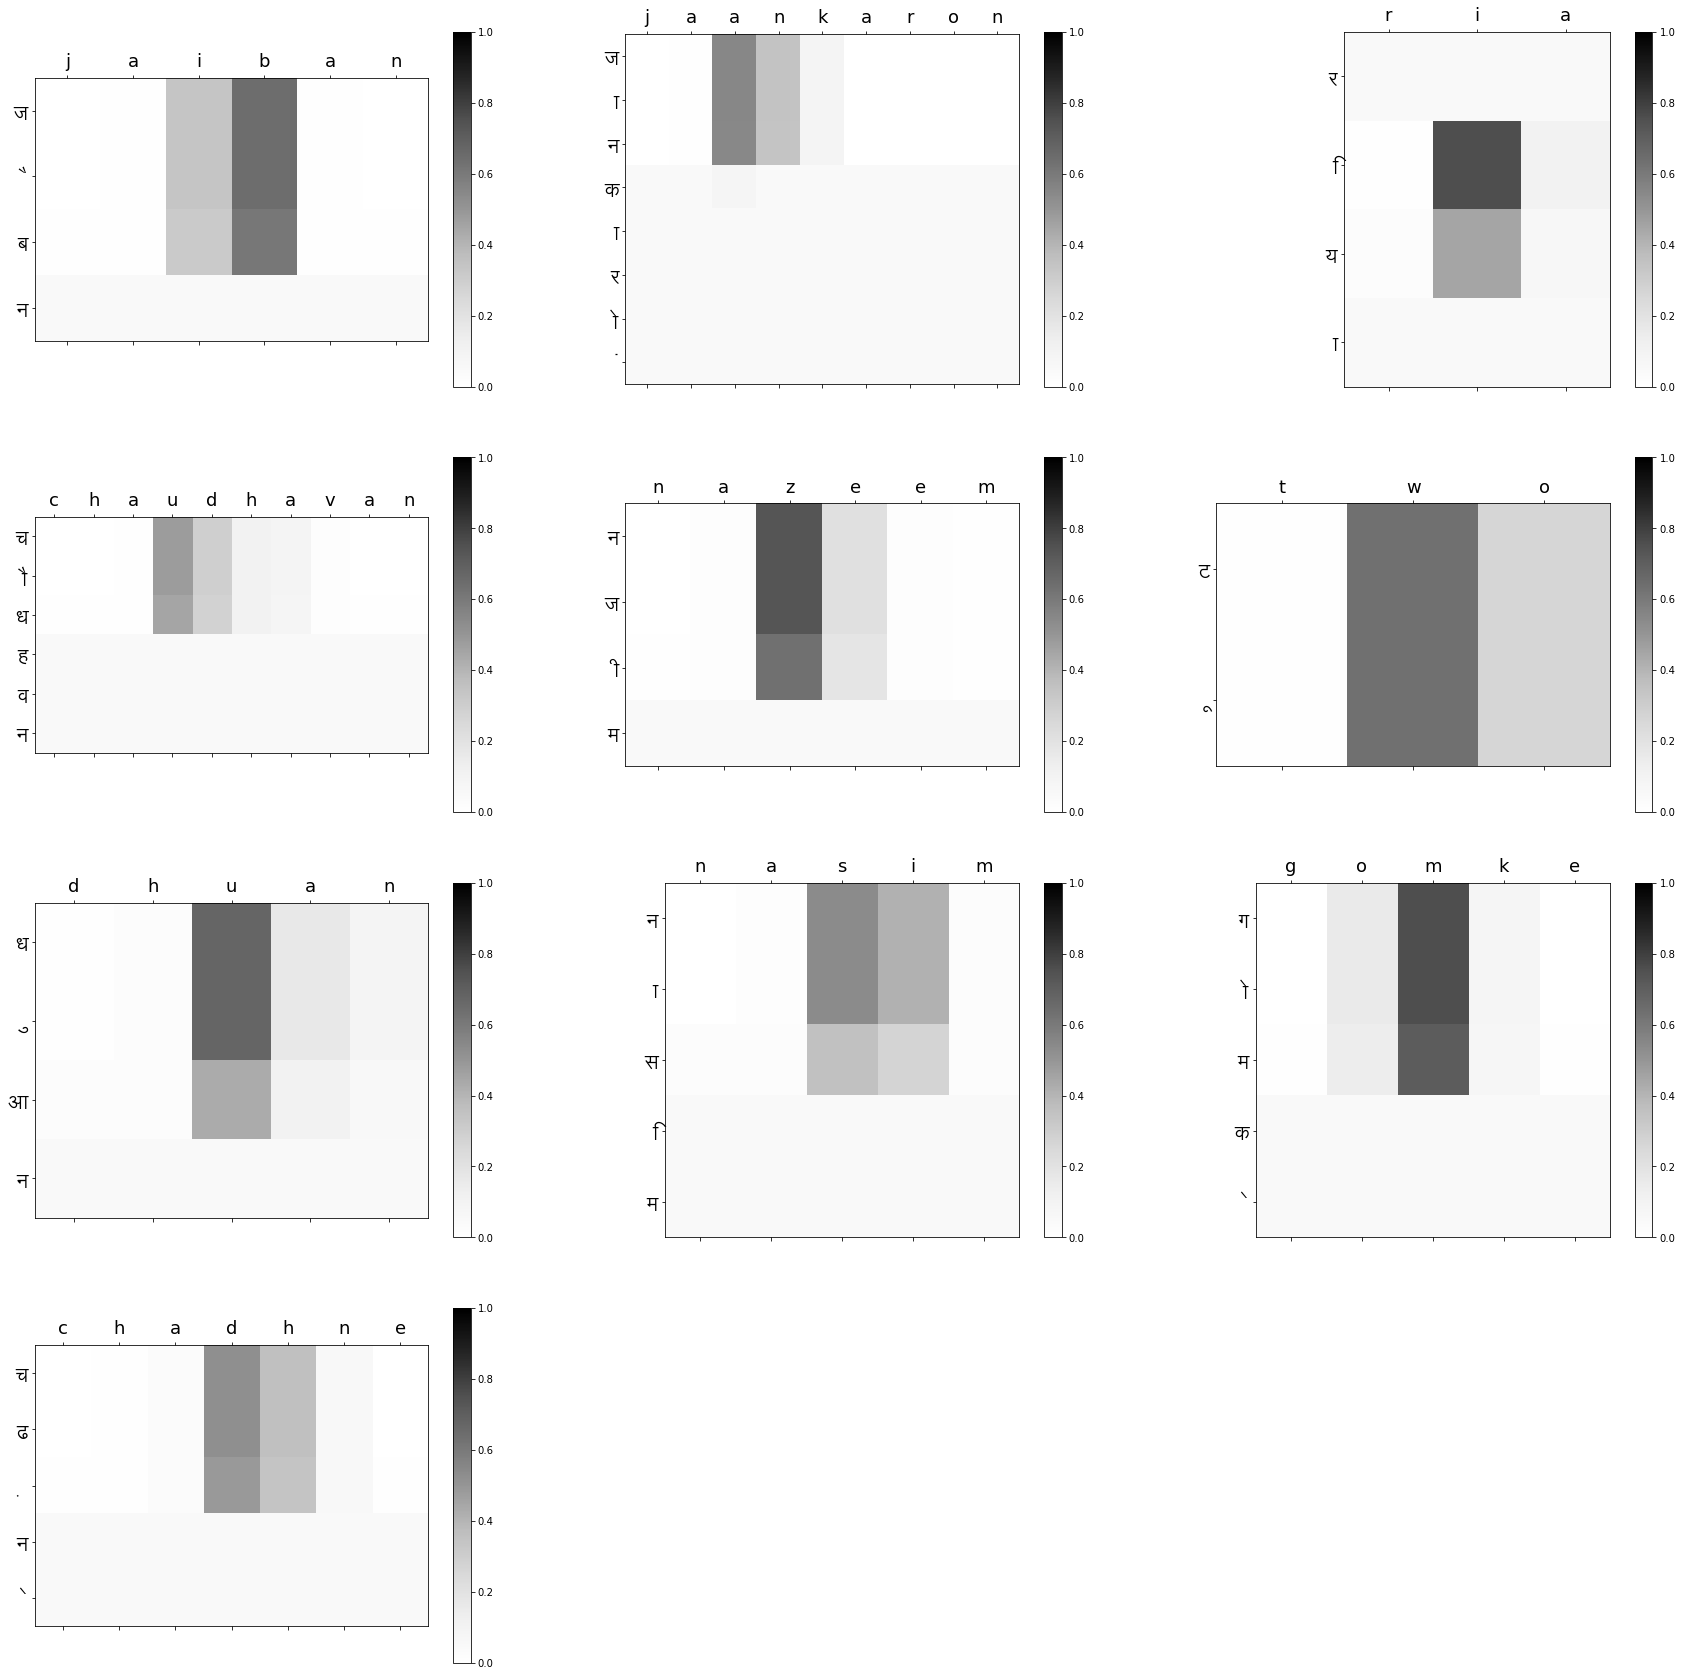

In [25]:
np.random.seed(10)
fig = plt.figure(figsize=(30, 30))
for i in range(10):
    seq_index = np.random.randint(len(test_X))
    input_seq = test_X[seq_index]
    plot_heatmap(model, input_seq, input_char_index, output_char_index, reverse_input_char_index, 
              reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
              num_encoder_tokens, num_decoder_tokens, device, fig, i+1)
    
    visualize(model, input_seq, input_char_index, output_char_index, reverse_input_char_index, 
              reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
              num_encoder_tokens, num_decoder_tokens, device)
    
    print("\n")


In [24]:
import xlsxwriter

workbook = xlsxwriter.Workbook('predictions_attention_pytorch.xlsx')
worksheet = workbook.add_worksheet()

worksheet.write(0, 0, "Input Word")
worksheet.write(0, 1, "Correct Output")
worksheet.write(0, 2, "Decoded Word")
worksheet.write(0, 3, "Exact Match")

total_words = len(test_X)
correct_pred = 0

for i in range(total_words):
    
    decoded_sentence, _ = translate(model, test_X[i], input_char_index, output_char_index, reverse_input_char_index, 
              reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
              num_encoder_tokens, num_decoder_tokens, device)
    
    worksheet.write(i+1, 0, test_X[i])
    worksheet.write(i+1, 1, test_Y[i])
    worksheet.write(i+1, 2, decoded_sentence)
    
    if test_Y[i][1:-1] == decoded_sentence:
        correct_pred += 1
        worksheet.write(i+1, 3, "Yes")
    else:
        worksheet.write(i+1, 3, "No")
        
    
test_accuracy = correct_pred / total_words

print(test_accuracy)

workbook.close()

0.30919591292758775


In [25]:
inp = []
cor = []
dec = []
ex = []

np.random.seed(10)
for index in range(20):
    seq_index = np.random.randint(len(test_X))
    input_seq = test_X[seq_index]
    decoded_sentence, _ = translate(model, input_seq, input_char_index, output_char_index, reverse_input_char_index, 
              reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
              num_encoder_tokens, num_decoder_tokens, device)

    if test_Y[seq_index][1:-1] == decoded_sentence:
        ex.append("Yes")
    else:
        ex.append("No")        
        
    inp.append(input_seq)
    cor.append(test_Y[seq_index][1:-1])
    dec.append(decoded_sentence)

import pandas as pd

grid = {'Input Word': inp, 'Correct Output' : cor, 'Decoded Word' : dec, "Exact Match" : ex}
pd.DataFrame(grid)

,Input Word,Correct Output,Decoded Word,Exact Match
0,jaiban,जयबाण,जैबन,No
1,jaankaron,जानकारों,जानकारों,Yes
2,ria,रिया,रिया,Yes
3,chaudhavan,चौदहवां,चौधहवन,No
4,nazeem,नजीम,नजीम,Yes
5,two,टु,टू,No
6,dhuan,धुआं,धुआन,No
7,nasim,नसीम,नासिम,No
8,gomke,गोमके,गोमके,Yes
9,chadhne,चढ़ने,चढ़ने,Yes
